## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [3]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
from sklearn.model_selection import train_test_split

# apply log to price
df['price'] = np.log1p(df.price)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(len(df_train), len(df_val), len(df_test))

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

del df_train['price']
del df_val['price']
del df_test['price']

29337 9779 9779


Now, use `DictVectorizer` to turn train and validation into matrices:

In [5]:
from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

# Decision tree regressor
dt_reg = DecisionTreeRegressor(max_depth=1)

# Call fit() on entr_model, and pass in X_train and y_train, in that order 
dt_reg.fit(X_train, y_train)

print(export_text(dt_reg, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_reg = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf_reg.fit(X_train,y_train)
y_pred = rf_reg.predict(X_val)

print(round(np.sqrt(mean_squared_error(y_val,y_pred)),3))

0.462


What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

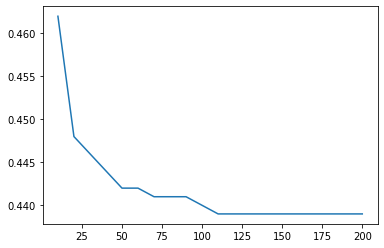

In [8]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = round(np.sqrt(mean_squared_error(y_val,y_pred)),3)
    
    scores.append((n, rmse))
    
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [9]:
scores = []

for d in [10,15,20,25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = round(np.sqrt(mean_squared_error(y_val,y_pred)),3)
    
        scores.append((n,d, rmse))
    
df_scores = pd.DataFrame(scores, columns=['n_estimators','max_depth', 'rmse'])


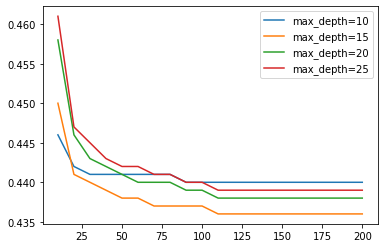

In [10]:
for d in [10,15,20,25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

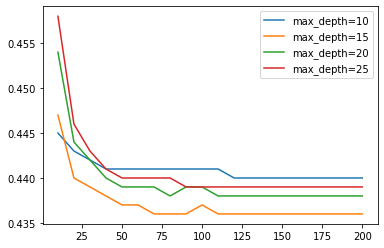

In [11]:
scores = []

for d in [10,15,20,25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=2021, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = round(np.sqrt(mean_squared_error(y_val,y_pred)),3)
    
        scores.append((n,d, rmse))
    
df_scores = pd.DataFrame(scores, columns=['n_estimators','max_depth', 'rmse'])

for d in [10,15,20,25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

Looks like changing random state does not change the outcome on best max_depth.

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

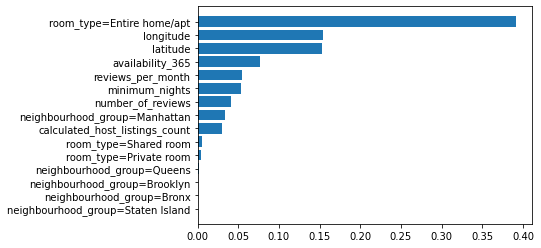

In [12]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(dv.get_feature_names())[indices])

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` first to `0.1` and then to `0.01`

In [13]:
import xgboost as xgb

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [14]:
scores = {}

In [15]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [16]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_squarederror', 'val_squarederror']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [17]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [18]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [19]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [20]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [21]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [22]:
scores

{'eta=0.3':     num_iter  train_squarederror  val_squarederror
 0          0             3.02752           3.02415
 1          5             0.67490           0.67752
 2         10             0.43912           0.44981
 3         15             0.42259           0.43827
 4         20             0.41716           0.43691
 5         25             0.41365           0.43621
 6         30             0.40712           0.43543
 7         35             0.40444           0.43510
 8         40             0.40103           0.43466
 9         45             0.39723           0.43371
 10        50             0.39446           0.43384
 11        55             0.39129           0.43378
 12        60             0.38743           0.43404
 13        65             0.38421           0.43450
 14        70             0.38117           0.43467
 15        75             0.37801           0.43489
 16        80             0.37668           0.43526
 17        85             0.37259           0.43537
 

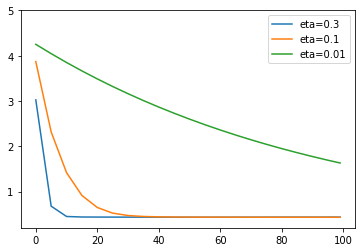

In [23]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_squarederror, label=eta)

plt.ylim(0.2, 5)
plt.legend()

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

